In [1]:

import numpy as np
from utils import helpers as h
from utils import settings as s
from analysis import analysis

2024-08-08 13:23:46,929 [INFO] utils.settings: Loaded config from C:\Users\petre\Documents\GitHub\MATSimPipeline/settings.yaml


C:\Users\petre\Documents\GitHub\MATSimPipeline\utils\helpers.py:86: DtypeWarning: Columns (276,278,279,287,292,313,317,370,381,382,384,389,395,396,401,402,405,406,407,408) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, sep=',', usecols=use_cols)


2024-08-08 13:26:54,829 [WARNING] utils.data_frame_processor: DataFrame is not yet initialized.
2024-08-08 13:26:54,830 [INFO] utils.data_frame_processor: DataFrame loaded and concatenated successfully from CSV.


C:\Users\petre\Documents\GitHub\MATSimPipeline\utils\helpers.py:86: DtypeWarning: Columns (276,278,279,287,292,313,317,370,381,382,384,389,395,396,401,402,405,406) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, sep=',', usecols=use_cols)


2024-08-08 13:26:56,437 [WARNING] utils.data_frame_processor: DataFrame is not yet initialized.
2024-08-08 13:26:56,443 [INFO] utils.data_frame_processor: DataFrame loaded and concatenated successfully from CSV.


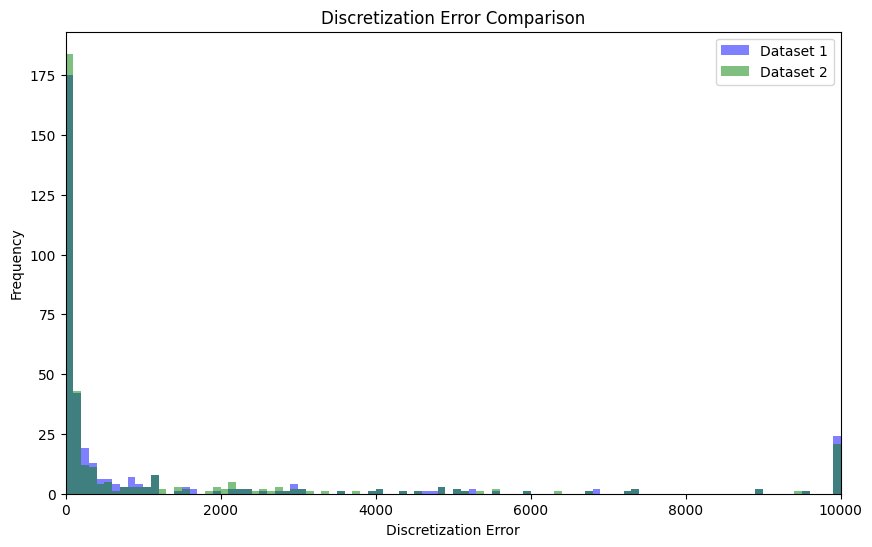

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the necessary functions and classes are imported from 'analysis' and 'h'

# First Dataset
Data1 = analysis.DataframeAnalysis()
Data1.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20240808_131516\location_assignment_result.csv')
Data1.df = Data1.df[Data1.df['to_location'].notna()]
Data1.df['from_location'] = Data1.df['from_location'].apply(h.convert_to_point)
Data1.df['to_location'] = Data1.df['to_location'].apply(h.convert_to_point)
Data1.evaluate_distance_deviations_from_df()

# Second Dataset
Data2 = analysis.DataframeAnalysis()
Data2.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20240808_131819\location_assignment_result.csv')
Data2.df = Data2.df[Data2.df['to_location'].notna()]
Data2.df['from_location'] = Data2.df['from_location'].apply(h.convert_to_point)
Data2.df['to_location'] = Data2.df['to_location'].apply(h.convert_to_point)
Data2.evaluate_distance_deviations_from_df()

# Ensure the maximum value is limited to 1000
Data1.df['discretization_error'] = Data1.df['discretization_error'].clip(upper=1000)
Data2.df['discretization_error'] = Data2.df['discretization_error'].clip(upper=1000)

# Plotting in the same plot
plt.figure(figsize=(10, 6))

# Plot histogram for Dataset 1
Data1.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='blue', label='Dataset 1')

# Plot histogram for Dataset 2
Data2.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='green', label='Dataset 2')

# Adding title and labels
plt.title('Discretization Error Comparison')
plt.xlabel('Discretization Error')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.legend()

plt.show()


mean, median, plot deviation dist, the same per chain, -- capacity matching??

In [3]:
Data1.df['discretization_error'].describe()

count     363.000000
mean      343.058652
std       408.071787
min         0.299952
25%        18.415942
50%       115.430781
75%       832.794164
max      1000.000000
Name: discretization_error, dtype: float64

In [4]:
Data2.df['discretization_error'].describe()


count     363.000000
mean      348.331761
std       416.356771
min         0.024504
25%        22.317046
50%        97.324317
75%      1000.000000
max      1000.000000
Name: discretization_error, dtype: float64